### Example E.5.3. BAYESIAN STUDENT-T REGRESSION from https://openreview.net/pdf?id=HltJfwwfhX

In [ ]:
import pystan
import pandas as pd
import numpy as np
import requests
import sys
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import rpy2py
import rpy2.robjects as ro
import json
import jax
from collections import OrderedDict
import gc
import os

from scipy.special import logsumexp

from amis_algorithms import alpha_AMIS_fixed_dof, AMIS_student_fixed_dof

import bridgestan

from utils import old_ksd

import matplotlib.pyplot as plt

import pickle

# Enable LaTeX for nicer plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


# from tueplots import bundles
# plt.rcParams.update(bundles.aistats2023())

from experiments_amis import run_AMIS_real_dataset


# Load and prepare the dataset
url = "https://github.com/faosorios/heavy/blob/master/data/creatinine.rda?raw=true"
with requests.get(url) as resp:
    with open("creatinine.rda", "wb") as f:
        f.write(resp.content)

# Load RDA file into Python
ro.r['load']("creatinine.rda")
df = pandas2ri.rpy2py_dataframe(ro.r['creatinine'])

data_df = pd.DataFrame(columns=['log_SC', 'log_WT', 'log_140_minus_A', 'log_CR'])

# Apply transformations following https://openreview.net/pdf?id=HltJfwwfhX
data_df['log_SC'] = np.log(df['SC'])
data_df['log_WT'] = np.log(df['WT'])
data_df['log_CR'] = np.log(df['CR'])
data_df['log_140_minus_A'] = np.log(140 - df['Age'])
data_df = data_df.dropna() # remove any rows with NaN values after transformation

# Compile the Stan model
sm = pystan.StanModel(file="./student_reg_model.stan")

# Prepare data for Stan model
data_for_stan = {
    'N': len(data_df),
    'x1': data_df['log_SC'].values.tolist(),
    'x2': data_df['log_WT'].values.tolist(),
    'x3': data_df['log_140_minus_A'].values.tolist(),
    'y': data_df['log_CR'].values.tolist()  # response variable
}

# Save the data dictionary to a JSON file
with open("student_regression_data.json", "w") as f:
    json.dump(data_for_stan, f, indent=4)


# Fit the model and sample from the posterior using NUTS (NUTS paper: https://arxiv.org/abs/1111.4246)
fit = sm.sampling(data=data_for_stan, iter=100, chains=1)
mcmc_samples = fit.extract()

stan = "./student_reg_model.stan"
data = "./student_regression_data.json"
bridgestan_model = bridgestan.StanModel.from_stan_file(stan, data)

true_log_pdf = fit.log_prob

# Step 3: Find the MAP solution
map_sol = sm.optimizing(data=data_for_stan)

# Retrieve the values, extract the single element from each array, and convert to an ndarray
map_sol_array = np.array([value.item() for value in map_sol.values()])

map_sol_list = list(map_sol.values())
log_dens_at_map, _, hessian_at_map = bridgestan_model.log_density_hessian(theta_unc=map_sol_array, propto=True)



In [ ]:

dim = 4 # Fixed
dof_proposal = 3
mu_initial_proposal_laplace = map_sol_array

assert np.isclose(log_dens_at_map, fit.log_prob(map_sol_list))

# Negative inverse of the Hessian at the MAP solution used as covariance
cov_laplace = -np.linalg.inv(hessian_at_map)
assert np.all(np.linalg.eigvals(cov_laplace) > 0)
shape_initial_proposal_laplace = (dof_proposal - 2) / (dof_proposal) * cov_laplace


sigma_initial = 10
shape_initial = (dof_proposal - 2) / (dof_proposal) * sigma_initial * np.identity(dim)

# num_samples = int(1e5)
n_iter = 25
nb_runs = 1000

# random_mu_initial = np.random.multivariate_normal(mean=np.zeros(dim), cov=np.identity(dim), size=1)
# random_mu_initial = np.random.uniform(-1, 1, dim)
# shape_initial_proposal = (dof_proposal - 2) / (dof_proposal) * np.identity(dim)
mu_initial = np.ones(dim)

assert np.all(np.linalg.eigvals(shape_initial_proposal_laplace) > 0)

mu_initial = mu_initial_proposal_laplace
shape_initial = shape_initial_proposal_laplace


start = 1000
end = 5000

# Define the number of points you want
num_points = 5  # for example

# Generate equally spaced values between start and end
values = np.linspace(start, end, num_points)

# Convert the values to integers
int_values = values.astype(int)

list_num_samples = int_values

# mean_Z_all, std_Z_all, mean_ESS_all, mean_alphaESS_all, std_ESS_all, std_alphaESS_all = [], [], [], [], [], []
# mean_Z_baseline_all, std_Z_baseline_all, mean_ESS_baseline_all, mean_alphaESS_baseline_all, std_ESS_baseline_all, std_alphaESS_baseline_all = [], [], [], [], [], []
# print(list_num_samples)


In [ ]:
for num_samples in list_num_samples:

    if os.path.exists('./results/realdata/AMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_meanZ_baseline.npy"):
        print('Already done with ', num_samples)
        continue

    print('num_samples', num_samples)

    mean_Z_baseline, std_Z_baseline, mean_ESS_baseline, mean_alphaESS_baseline, std_ESS_baseline, std_alphaESS_baseline, adapted_proposal_AMIS = run_AMIS_real_dataset(alg=AMIS_student_fixed_dof, nb_runs=nb_runs, n_iterations=n_iter, log_pi_tilde=true_log_pdf, dof_proposal=dof_proposal, M=num_samples, d=dim, mu_initial=mu_initial, shape_initial=shape_initial)


    mean_Z, std_Z, mean_ESS, mean_alphaESS, std_ESS, std_alphaESS, adapted_proposal_alpha_AMIS = run_AMIS_real_dataset(alg=alpha_AMIS_fixed_dof, nb_runs=nb_runs, n_iterations=n_iter, log_pi_tilde=true_log_pdf, dof_proposal=dof_proposal, M=num_samples, d=dim, mu_initial=mu_initial, shape_initial=shape_initial)

    # print(mean_Z_baseline.shape)
    # print(mean_ESS_baseline.shape)

    np.save('./results/realdata/AMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_meanZ_baseline.npy", mean_Z_baseline)
    np.save('./results/realdata/AMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_stdZ_baseline.npy", std_Z_baseline)
    np.save('./results/realdata/AMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_ESS_baseline.npy", mean_ESS_baseline)
    np.save('./results/realdata/AMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_ESS_baseline.npy", std_ESS_baseline)
    np.save('./results/realdata/AMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_alphaESS_baseline.npy", mean_alphaESS_baseline)
    np.save('./results/realdata/AMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_alphaESS_baseline.npy", std_alphaESS_baseline)


    np.save('./results/realdata/alphaAMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_Z.npy", mean_Z)
    np.save('./results/realdata/alphaAMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_Z.npy", std_Z)
    np.save('./results/realdata/alphaAMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_ESS.npy", mean_ESS)
    np.save('./results/realdata/alphaAMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_ESS.npy", std_ESS)
    np.save('./results/realdata/alphaAMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_mean_alphaESS.npy", mean_alphaESS)
    np.save('./results/realdata/alphaAMIS/' + 'Laplaceinit_' + "_" + str(num_samples) + "_dof_" + str(dof_proposal) + "_nbruns_" + str(nb_runs) + "_niter_" + str(n_iter) + "_std_alphaESS.npy", std_alphaESS)

    del mean_Z_baseline,std_Z_baseline,mean_ESS_baseline,std_ESS_baseline,mean_alphaESS_baseline,std_alphaESS_baseline

    del mean_Z,std_Z,mean_ESS,std_ESS,mean_alphaESS,std_alphaESS

    gc.collect()

    # mean_ESS_baseline_all.append(mean_ESS_baseline)
    # mean_alphaESS_baseline_all.append(mean_alphaESS_baseline)
    #
    # std_ESS_baseline_all.append(std_ESS_baseline)
    # std_alphaESS_baseline_all.append(std_alphaESS_baseline)
    #
    # mean_Z_all.append(mean_Z)
    # std_Z_all.append(std_Z)
    #
    # mean_ESS_all.append(mean_ESS)
    # mean_alphaESS_all.append(mean_alphaESS)
    #
    # std_ESS_all.append(std_ESS)
    # std_alphaESS_all.append(std_alphaESS)


# Last key is the log probability, which we don't want
exclude_key = "lp__"
mcmc_samples = OrderedDict((k, v) for k, v in mcmc_samples.items() if k != exclude_key)

mcmc_samples_array = np.vstack(list(mcmc_samples.values())).T

In [ ]:
# load
def load_all_npy_files(directory):
    """
    Load all .npy files from a specified directory.

    Parameters:
    - directory (str): Path to the directory containing .npy files.

    Returns:
    - A dictionary with filenames as keys and loaded numpy arrays as values.
    """
    files = [f for f in os.listdir(directory) if f.endswith('.npy')]
    data = {}

    for f in files:
        full_path = os.path.join(directory, f)
        data[f] = np.load(full_path)

    return data

# Usage
directory_path = './results/realdata/AMIS/'
loaded_data = load_all_npy_files(directory_path)

In [ ]:
# def get_keys_containing_str(dictionary, substring):
#     """
#     Get all keys from a dictionary that contains a specified substring.
#
#     Parameters:
#     - dictionary (dict): The dictionary to search through.
#     - substring (str): The substring to look for in the keys.
#
#     Returns:
#     - list of str: A list of keys containing the substring. If no key is found, returns an empty list.
#     """
#     return [key for key in dictionary.keys() if substring in key]
#
# # Example Usage
# matching_keys = get_keys_containing_str(loaded_data, "")


In [ ]:
for key, value in loaded_data.items():
    print(f'Key: {key}, Value: {value.shape}')

In [ ]:
directory_path_alphaAMIS = './results/realdata/alphaAMIS/'
loaded_data_alphaAMIS = load_all_npy_files(directory_path_alphaAMIS)

In [ ]:
for key, value in loaded_data_alphaAMIS.items():
    print(f'Key: {key}, Value: {value.shape}')

# group by number of samples and type of metric

In [ ]:
dictionaries_data = [loaded_data, loaded_data_alphaAMIS]
results_baseline = {}
results_our_fixed_dof = {}
results_all = [results_baseline, results_our_fixed_dof]

for i, data in enumerate(dictionaries_data):
    for key, value in data.items():
        # Split the key by "_" and find the index of "niter_25_"
        parts = key.split("_")

        key_numsamples = parts[2]
        key_metric = parts[-3] + parts[-2] + parts[-1]

        if key_metric not in results_all[i].keys():
            results_all[i][key_metric] = {}
            if key_numsamples not in results_all[i][key_metric].keys():
                results_all[i][key_metric][key_numsamples] = value[-1] # keeping only last value of iteration number
            else:
                continue
        else:
            if key_numsamples not in results_all[i][key_metric].keys():
                results_all[i][key_metric][key_numsamples] = value[-1] # keeping only last value of iteration number
            else:
                continue

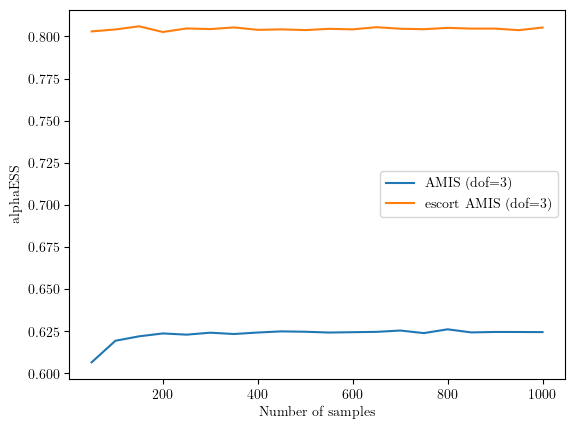

In [41]:
sorted_numsamples_baseline = sorted(list(map(int, results_baseline['meanalphaESSbaseline.npy'].keys())))
sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]
# Step 2: Iterate through the sorted keys and get the corresponding values
sorted_values_baseline = [ results_baseline['meanalphaESSbaseline.npy'][key] for key in sorted_numsamples_baseline_str]

sorted_numsamples_ours = sorted(list(map(int, results_our_fixed_dof['25meanalphaESS.npy'].keys())))
sorted_numsamples_ours_str = [str(num) for num in sorted_numsamples_ours]
# Step 2: Iterate through the sorted keys and get the corresponding values
sorted_values_ours = [ results_our_fixed_dof['25meanalphaESS.npy'][key] for key in sorted_numsamples_ours_str]


plt.plot(sorted_numsamples_baseline[:len(sorted_numsamples_baseline) -  3],  sorted_values_baseline[:len(sorted_numsamples_baseline) -  3], label='AMIS (dof=3)')
plt.plot(sorted_numsamples_ours[:len(sorted_numsamples_ours) -  3],  sorted_values_ours[:len(sorted_numsamples_ours) -  3], label='escort AMIS  (dof=3)')
plt.xlabel('Number of samples')
plt.ylabel('alphaESS')
plt.legend()
plt.savefig('./results/creatinine_alphaESS.pdf')


In [47]:
print(sorted_numsamples_baseline)

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 20929, 41758, 62587]


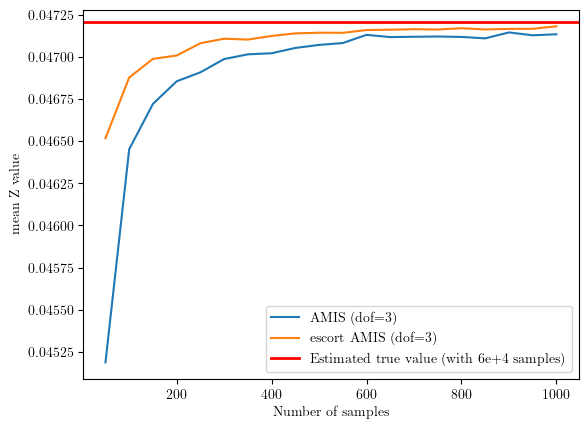

In [51]:
sorted_numsamples_baseline = sorted(list(map(int, results_baseline['25meanZbaseline.npy'].keys())))
sorted_numsamples_baseline_str = [str(num) for num in sorted_numsamples_baseline]
# Step 2: Iterate through the sorted keys and get the corresponding values
sorted_values_baseline = [ results_baseline['25meanZbaseline.npy'][key] for key in sorted_numsamples_baseline_str]

sorted_numsamples_ours = sorted(list(map(int, results_our_fixed_dof['25meanZ.npy'].keys())))
sorted_numsamples_ours_str = [str(num) for num in sorted_numsamples_ours]
# Step 2: Iterate through the sorted keys and get the corresponding values
sorted_values_ours = [ results_our_fixed_dof['25meanZ.npy'][key] for key in sorted_numsamples_ours_str]


plt.plot(sorted_numsamples_baseline[:len(sorted_numsamples_baseline) -  3],  sorted_values_baseline[:len(sorted_numsamples_baseline) -  3], label='AMIS (dof=3)')
plt.plot(sorted_numsamples_ours[:len(sorted_numsamples_ours) -  3],  sorted_values_ours[:len(sorted_numsamples_ours) -  3], label='escort AMIS  (dof=3)')
plt.axhline(y=sorted_values_ours[-1], color='r', linestyle='solid', lw=2, label='Estimated true value (with 6e+4 samples)')

plt.xlabel('Number of samples')
plt.ylabel('mean Z value')
plt.legend()
plt.savefig('./results/creatinine_meanZ_estimation.pdf')

[50,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 1000]

###  results

In [ ]:
print('Estimate by AMIS', mean_Z_baseline[-1], std_Z_baseline[-1])
print('Estimate by alpha AMIS', mean_Z[-1], std_Z[-1])



In [ ]:
print('ESS by AMIS', mean_ESS_baseline[-1], 1.96* std_ESS_baseline[-1])
print('alpha ESS by AMIS', mean_alphaESS_baseline[-1], 1.96*std_alphaESS_baseline[-1])
print('ESS by escort moment AMIS', mean_ESS[-1], 1.96*std_ESS[-1])
print('alpha ESS by by escort moment AMIS', mean_alphaESS[-1], 1.96* std_alphaESS[-1])


### Old: comparison with MCMC via KSD

In [ ]:
# def numpy_callback(x):
#   # Need to forward-declare the shape & dtype of the expected output.
#   result_shape = jax.core.ShapedArray(x.shape, x.dtype)
#   return jax.pure_callback(np.sin, result_shape, x)

def log_density_gradient_correct(theta):
    return bridgestan_model.log_density_gradient(theta)[1]

def log_density_gradient(theta):
    result_shape = jax.core.ShapedArray(theta.shape , theta.dtype)
    # _, gradient = bridgestan_model.log_density_gradient(theta)
    gradient = jax.experimental.io_callback(log_density_gradient_correct, result_shape, theta)
    return gradient

In [ ]:
jax.config.update("jax_enable_x64", True)
# compare results with MCMC via the KSD
ksd_mcmc_samples = old_ksd(mcmc_samples_array, log_density_gradient)
print("KSD using true samples:", ksd_mcmc_samples)



In [ ]:
from scipy.special import logsumexp

final_samples = adapted_proposal.rvs(size=50000)

weights = bridgestan_model.log_density(final_samples) - adapted_proposal.logpdf(final_samples)
normalized_weights = np.exp(weights - logsumexp(weights))
ksd_fixed_dof = old_ksd(final_samples, log_density_gradient, weights=normalized_weights)
print("KSD for adapted proposal samples:", ksd_fixed_dof)
